## 1) Qiskit Transpilation

In [1]:
# https://qiskit.org/documentation/apidoc/transpiler.html

**Transpilation** is transformation of given virtual quantum circuit:
- to match the topology of a specific device
- to optimize the circuit for execution

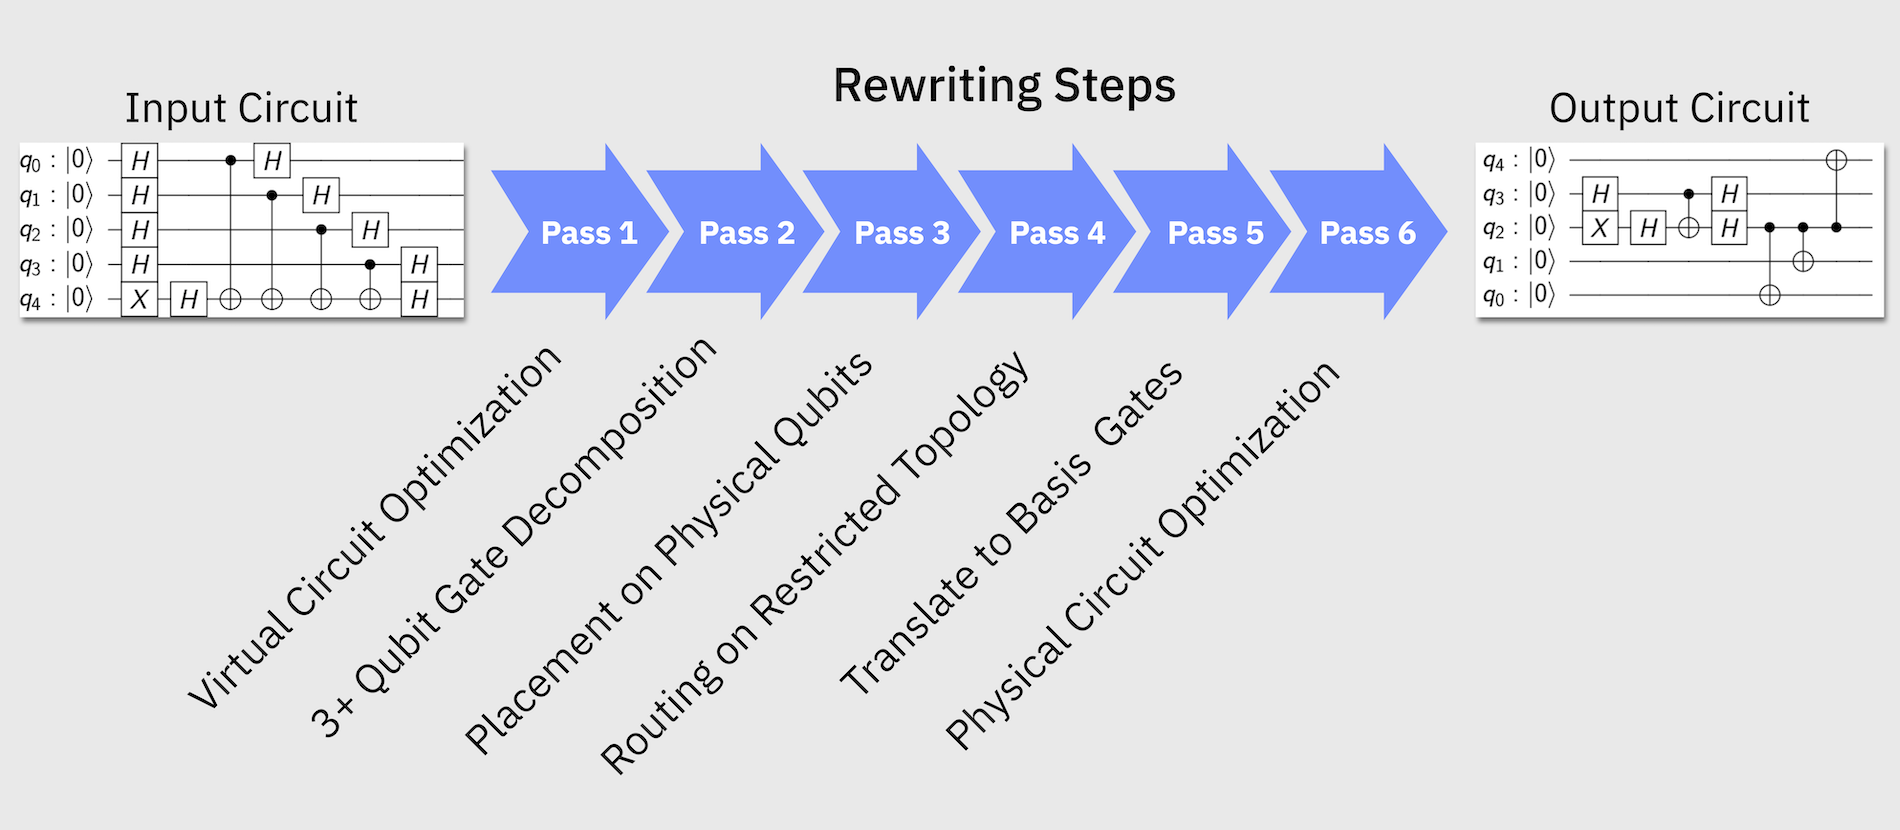

Six stages of transpilation:

1) **Init** - Unrolling custom instructions and converting the circuit to all 1 and 2 qubit gates.

2) **Layout** - Mapping circuit virtual qubits to backend physical qubits.

3) **Routing** - Inject SWAP gates to comply with the backend’s coupling map.

4) **Translation** - Translate to the target backend’s basis gate set.

5) **Optimization** - Main optimization loop to increase circuit quality.

6) **Scheduling** - Conversion to hardware-specific pulses.

### 2. Layout Stage

Quantum circuits are abstract entities whose qubits are “virtual” representations of actual qubits used in computations. We need to be able to map these virtual qubits in a one-to-one manner to the “physical” qubits in an actual quantum device.

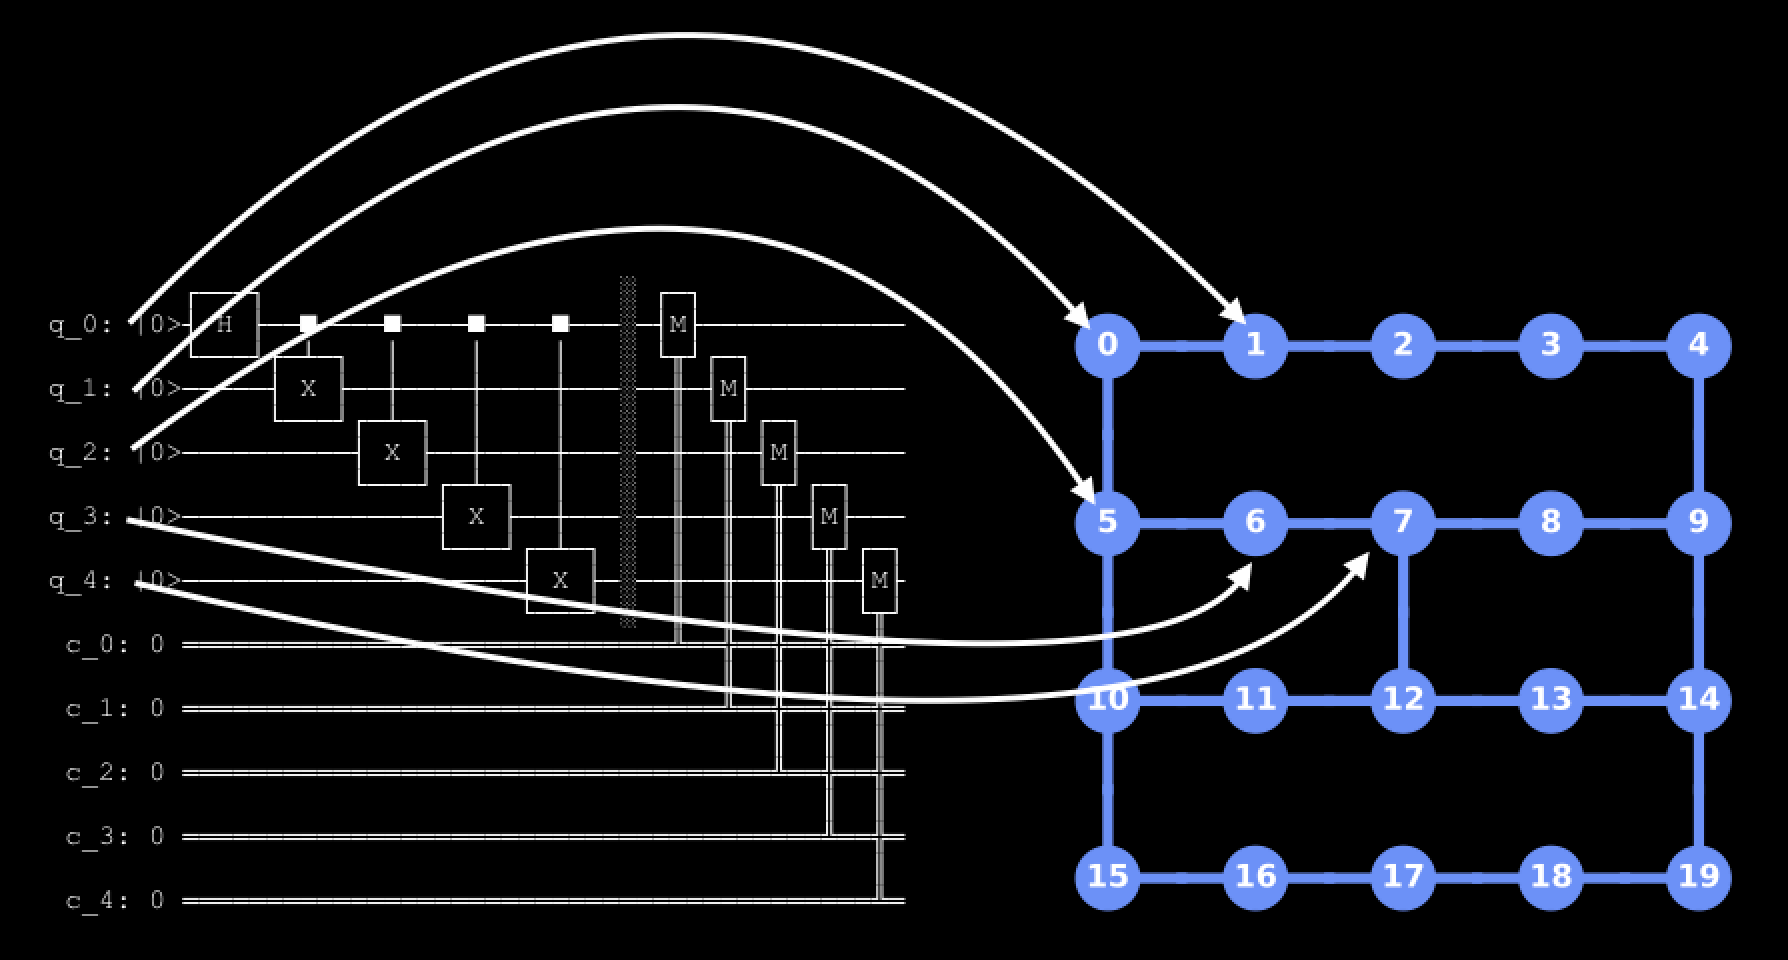

Layout method depends on:

- Circuit structure
- Device coupling map and noise model
- Optimization level

**Initial layout** defines *initial* mapping of circuit virtual qubits to backend physical qubits.

The choice of initial layout is extremely important:

- for minimizing the number of SWAP operations needed to map to device topology
- for minimizing the loss due to non-uniform noise properties across a device

### Layout search steps

1) Perfect layout search - tries to find a layout which does not require any SWAP operations.
2) Heuristic layout search - best layout to use if a Perfect layout cannot be found.

#### Perfect layout search

- **TrivialLayout** - Map each virtual qubit to the same numbered physical qubit on the device.

- **VF2Layout** - Searches for backend connectivity subgraph that is isomporphic to circuit connectivity graph. Then rank subgraphs by error.

#### Heuristic layout search

- **DenseLayout** - Prioritises qubits with more connections.

- **SabreLayout** - Starts from an initial random layout - then repeatedly runs a routing algorithm forwards and backwards over the circuit - to adjust initial random layout.

### 3) Routing Stage

Inserts SWAP gates to move qubits around device topology to place all 2-qubit gates.

- SWAP gates are expensive and noisy.

- Minimizing number of SWAPs is very important.

- Finding optimal routing is NP-hard problem.

- Stochastic heuristic **SabreSwap** algorithm is used.

**SabreSwap** runs in parallel with different seed values:

- Parameter *trials* specifies number of parallel trials.

- Result with minimum number of SWAPs is selected.

Afterwards **VF2PostLayout** pass tries to find a layout on qubits with lower error rates.

## 2) Transpilation Examples

In [2]:
import numpy as np

import functools

import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from matplotlib import pyplot as plt

plt.style.use("dark_background")
    
%run transpiler_demo_backend.ipynb

### Litmus Circuit

In [3]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Backend

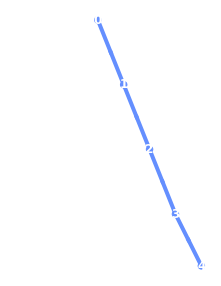

In [4]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

backend_qubits_count = getattr(backend, 'num_qubits',
                               backend.configuration().num_qubits)

backend_qubits = list(range(backend_qubits_count))

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Qiskit Transpiler

In [5]:
transpiled_litmus_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

### Pass Manager

In [6]:
pass_manager = qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager(
    
    optimization_level=3,
    backend=backend,
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234,
)

# pass_manager.draw()

In [7]:
pass_manager.stages

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')

In [8]:
# pass_manager.init.draw()

In [9]:
# pass_manager.optimization.draw()

In [10]:
# pass_manager.routing.draw()

In [11]:
# pass_manager.layout.passes()

In [12]:
transpiled_litmus_circuit = pass_manager.run(litmus_circuit)

transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

## 3) Circuit Stitching

**Task:** to "stitch" together transpiled circuits into a chain.

Disconnected qubits are routed closer using SWAPs gates – **but not routed back** to avoid additional SWAPs – therefore allocation of virtual qubit changes.

We need to know final allocation of qubits after transpilation.

Unfortunately, Qiskit does not provide such allocation.

Instead - Qiskit transpiled circuit contains ‘layout’ property with data on applied qubit permutations:

- ‘initial_layout’ – initial placement of incoming virtual qubits during Layout stage.

- ‘final_layout’ – placement of outgoing virtual qubits during Routing stage.

Function ‘get_full_map’ follows above permutations to return final allocation of qubits after transpilation.

In [13]:
get_full_map(transpiled_litmus_circuit)

[1, 3, 2, 0, 4]

To find final allocation of qubits after transpilation we work with 3 sets of qubits:

- Incoming virtual qubits of initial circuit
- Outgoing virtual qubits of transpiled circuit
- Physical qubits of selected backend

In [14]:
transpiled_litmus_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

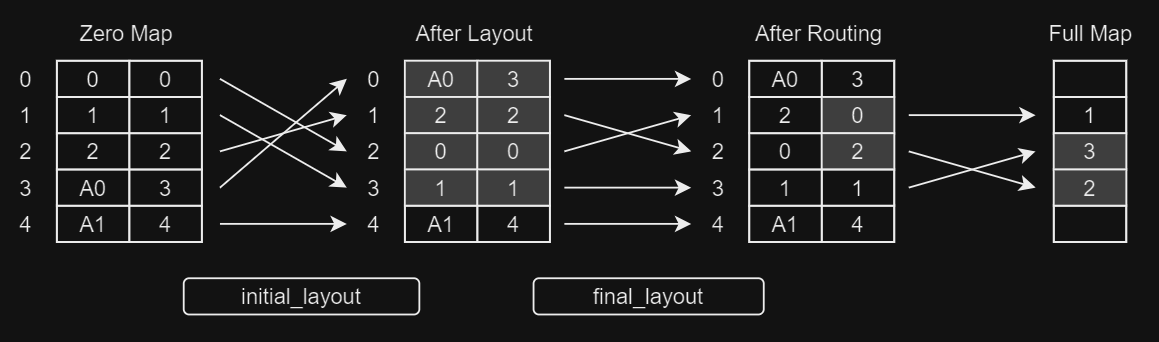

In [15]:
# get_full_map(transpiled_litmus_circuit, printout=True)

### Our Transpile

In [16]:
transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    optimization_level=3,
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

In [17]:
get_full_map(transpiled_litmus_circuit)

[1, 3, 2, 0, 4]

### Transpile and Return Options

In [18]:
transpiled_litmus_circuit, options = transpile_and_return_options(
    litmus_circuit, 
    backend,
    optimization_level=3,
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(fold=-1)

options

{'optimization_level': 3,
 'seed_transpiler': 1234,
 'backend': AerSimulator(''aer_simulator(Fake5QV2)'),
 'full_map': [1, 3, 2, 0, 4],
 'arguments': (),
 'original_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f256cec21c0>,
 'transpiled_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f255c0cacd0>}

In [19]:
transpiled_litmus_circuit, options = transpile_and_return_options(
    litmus_circuit, 
    pass_manager=pass_manager,
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

### Transpile Chain

In [20]:
CHAIN = [
    litmus_circuit, 
    litmus_circuit, 
    litmus_circuit
]

transpiled_chain_litmus_circuit = transpile_chain(
    CHAIN, 
    backend,
    # initial_layout=[1, 0, 4],
    seed_transpiler=1234,
)

transpiled_chain_litmus_circuit.draw(fold=-1)

global phase: -1.5*Litmus_0 - 1.5*Litmus_1 - 1.5*Litmus_2
                                                                                                                          ░                                                                  ░ 
q_0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
     ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌─────────────────┐                                        ┌───┐ ░ ┌─────────────────┐                                        ┌───┐ ░ 
q_1: ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─
     ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├─────────────────┤┌───┐     ┌───┐┌─┴─┐     ┌───┐     ┌───┐└─┬─┘ ░ ├─────────────────┤┌───┐     ┌───┐┌─┴─┐     ┌───┐     ┌───┐└─┬─┘ ░ 
q_2: ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─
     ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├─────────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘      ░ ├─────────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘      ░ 
q_3: ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─
     └─────────────────┘└───┘                          ░ └─────────────────┘     └───┘          └───┘     └───┘           ░ └─────────────────┘     └───┘          └───┘     └───┘           ░ 
q_4: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
                                                                                                                          ░                                                                  ░

### Transpile Right

In [21]:
display(transpiled_litmus_circuit.draw(fold=-1))

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

In [22]:
cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT", [0, 1])

display(cnot_circuit.draw(fold=-1))

┌────────────┐      CNOT 
CNOT_0_0: ┤ Rz(CNOT_0) ├──■────░───
          ├────────────┤┌─┴─┐  ░   
CNOT_0_1: ┤ Rz(CNOT_1) ├┤ X ├──░───
          ├────────────┤└───┘  ░   
CNOT_0_2: ┤ Rz(CNOT_2) ├───────░───
          └────────────┘       ░

In [23]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_litmus_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

display(transpiled_right_circuit.draw(fold=-1))

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░ 
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─
                                                                                                          ░

In [24]:
get_full_map(transpiled_right_circuit)

[1, 2, 3, 0, 4]

### Transpile Left

In [25]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_litmus_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                
ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────
               ┌───────────────────┐      ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
 CNOT_0_2 -> 1 ┤ U(0,1.0*CNOT_2,0) ├──────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
               ├───────────────────┤      ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
 CNOT_0_0 -> 2 ┤ U(0,1.0*CNOT_0,0) ├──■───░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
               ├───────────────────┤┌─┴─┐ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
 CNOT_0_1 -> 3 ┤ U(0,1.0*CNOT_1,0) ├┤ X ├─░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
               └───────────────────┘└───┘ ░ └─────────────────┘└───┘                          ░ 
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────

In [26]:
get_full_map(transpiled_left_circuit)

# [1, 3, 2, 0, 4]

[1, 3, 2, 0, 4]

### IBM Cost

IBM Cost can be used as circuit quality metric.

IBM Cost is a product of gate fidelities and depth penalization:

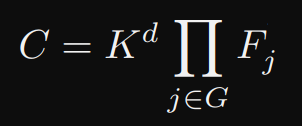

* K - circuit depth penalization factor
* d - circuit depth
* G - gates
* F - fidelities

[1] “Demonstration of quantum volume 64 on a superconducting quantum computing system” – IBMQ – P. Jurcevic, A. Javadi-Abhari, L. S. Bishop and others – https://arxiv.org/abs/2008.08571

In [27]:
get_ibm_cost(litmus_circuit)

0.9498972910479807

In [28]:
get_ibm_cost(transpiled_litmus_circuit)

0.9079281368512877

## 4) Amplitude Encoding + Quantum Fourier Transform

To test transpilation consistency - we take 2 blocks:

* **Amplitude Encoding (AE)** - encodes signal of multiple sinusoids with specified frequencies and amplitudes.
* **Quantum Fourier Transform (QFT)** - converts above signal to frequency domain.

Different types of transpilation should show similar results - with spectrum peaks corresponding to frequencies of encoded signal.

We are comparing 3 types of transpilation:

* **Combined**: circuit is composed from selected parts, then transpiled altogether.
* **Blocks**: parts are transpiled one-by-one and then composed.
* **Chain**: parts are transpiled one-by-one using ‘transpile_chain’ and then composed.

Comparison between **Combined** and **Blocks** checks if stitching is correct.
Comparison between **Blocks** and **Chain** checks if ‘transpile_chain’ is correct and ‘transpiler_options’ are passed correctly.


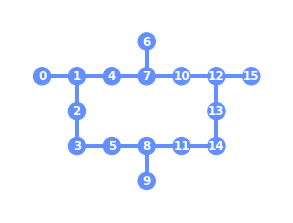

In [29]:
QUBITS_COUNT = 8

# LAYOUT_METHOD = 'sabre'
LAYOUT_METHOD = None
# ROUTING_METHOD = 'sabre'
ROUTING_METHOD = None

# ‘trivial’, ‘dense’, ‘noise_adaptive’, ‘sabre’
# ‘basic’, ‘lookahead’, ‘stochastic’, ‘sabre’, ‘none’

SHOTS_COUNT = 1000
SEED_TRANSPILER = 1234
OPTIMIZATION_LEVEL = 3

qubits = list(range(QUBITS_COUNT))


# Backend

# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

backend_qubits_count = getattr(backend, 'num_qubits',
                               backend.configuration().num_qubits)

backend_qubits = list(range(backend_qubits_count))

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Sinusoids

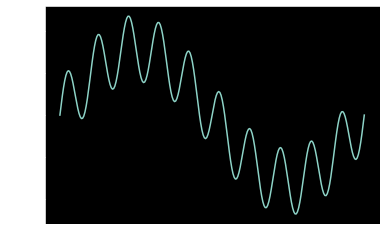

In [30]:
# sinusoids_data = get_sinusoids(QUBITS_COUNT, frequencies=[1])

# sinusoids_data = get_sinusoids(QUBITS_COUNT, 1)

sinusoids_data = get_sinusoids(QUBITS_COUNT, 
                               frequencies=[1, 10],
                               amplitudes=[10, 5])

plt.plot(sinusoids_data);

### 1) Combined Circuit

In [31]:
# AE Part

amplitude_embedding = qiskit.circuit.library.StatePreparation(sinusoids_data)

ae_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)
ae_circuit.append(amplitude_embedding, qargs=qubits)
ae_circuit.barrier()

# QFT Part

qft = qiskit.circuit.library.QFT(num_qubits=QUBITS_COUNT)

qft_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)
qft_circuit.append(qft, qargs=qubits)
qft_circuit.barrier()

# Measurement Part

measurement_circuit = qiskit.QuantumCircuit(QUBITS_COUNT, QUBITS_COUNT)
measurement_circuit.measure(qubits, qubits);

# Combined Circuit

combined_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)

combined_circuit.append(amplitude_embedding, qargs=qubits)
combined_circuit.append(qft, qargs=qubits)
combined_circuit.compose(measurement_circuit, inplace=True)

# combined_circuit.measure_active()

# combined_circuit.draw(fold=-1)

In [32]:
# Run

transpiled_combined_circuit = qiskit.transpile(
    combined_circuit, 
    backend,
    # initial_layout=qubits,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

combined_job = backend.run(transpiled_combined_circuit, shots=SHOTS_COUNT)

combined_result = combined_job.result()

combined_counts = combined_result.get_counts()

# print("combined_counts:", combined_counts)

# qiskit.visualization.plot_histogram(combined_counts, title="Combined AE and QFT")

### 2) Blocks Circuit

In [33]:
# AE

transpiled_ae_circuit = qiskit.transpile(
    ae_circuit,
    backend,
    # initial_layout=qubits,
    # initial_layout=[1, 3, 0],
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,    
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

full_map_ae = get_full_map(transpiled_ae_circuit)

In [34]:
# transpiled_ae_circuit.draw(fold=-1)

In [35]:
# qiskit.visualization.plot_circuit_layout(transpiled_ae_circuit, FAKE_BACKEND)

In [36]:
# QFT

initial_layout = full_map_ae[:qft_circuit.num_qubits]

transpiled_qft_circuit = qiskit.transpile(
    qft_circuit,
    backend,
    initial_layout=initial_layout,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

full_map_qft = get_full_map(transpiled_qft_circuit)

# transpiled_qft_circuit.draw(fold=-1)

In [37]:
# qiskit.visualization.plot_circuit_layout(transpiled_qft_circuit, FAKE_BACKEND)

In [38]:
initial_layout = full_map_qft[:measurement_circuit.num_qubits]

transpiled_measurement_circuit = qiskit.transpile(
    measurement_circuit,
    backend,
    initial_layout=initial_layout,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

# transpiled_measurement_circuit.draw(fold=-1)

In [39]:
# Block Circuit

blocks_circuit = qiskit.QuantumCircuit(backend_qubits_count)

blocks_circuit.compose(
    transpiled_ae_circuit,
    qubits=backend_qubits,
    inplace=True
)

blocks_circuit.compose(
    transpiled_qft_circuit,
    qubits=backend_qubits,
    inplace=True
)

blocks_circuit.compose(
    transpiled_measurement_circuit,
    qubits=backend_qubits,
    inplace=True
)

# blocks_circuit.draw(fold=-1)

In [40]:
# Run

transpiled_blocks_circuit = qiskit.transpile(
    blocks_circuit,
    backend=backend
)

blocks_job = backend.run(transpiled_blocks_circuit, 
                         shots=SHOTS_COUNT)

blocks_counts = blocks_job.result().get_counts()

### 3) Chain Circuit

In [41]:
CHAIN = [
    ae_circuit,
    qft_circuit,
    measurement_circuit
]

transpiled_chain_circuit = transpile_chain(
    CHAIN, 
    backend,
    # initial_layout=qubits,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

chain_job = backend.run(transpiled_chain_circuit, 
                        shots=SHOTS_COUNT)

chain_counts = chain_job.result().get_counts()

### Plots

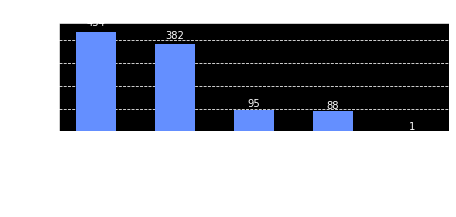

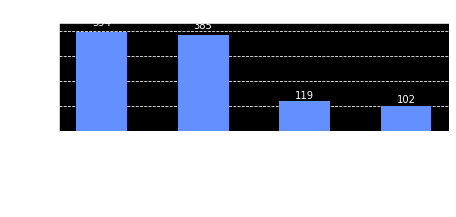

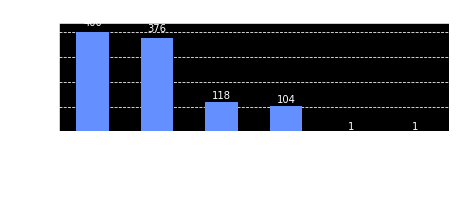

In [42]:
display(qiskit.visualization.plot_histogram(
    combined_counts,
    figsize=(7, 2),
    sort='value_desc',
    title="Combined AE and QFT"
))

display(qiskit.visualization.plot_histogram(
    blocks_counts,
    figsize=(7, 2),
    sort='value_desc',
    title="Blocks AE and QFT"
))

display(qiskit.visualization.plot_histogram(
    chain_counts,
    figsize=(7, 2),
    sort='value_desc',
    title="Chain AE and QFT"
))

**Conclusion:**

Resulting spectrа are similar for **Combined**, **Blocks** and **Chain** transpilation types.

This confirms consistency of transpilation for AE and QFT circuit.

## 5) Transpilation Stacks

### DAG

In [43]:
transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

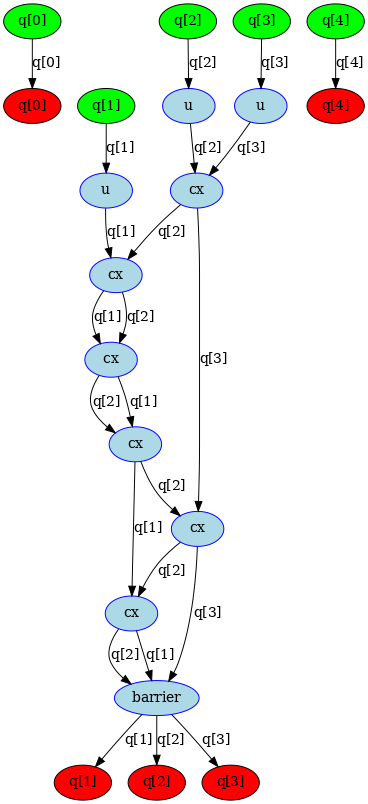

In [44]:
dag = qiskit.converters.circuit_to_dag(transpiled_litmus_circuit)

dag.draw()

In [45]:
circuit_from_dag = qiskit.converters.dag_to_circuit(dag)

circuit_from_dag.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                         
q_0: ────────────────────────────────────────────────────
     ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
q_1: ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
     ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
q_2: ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
     ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
q_3: ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
     └─────────────────┘└───┘                          ░ 
q_4: ────────────────────────────────────────────────────

### Stacks

In [46]:
QSEARCH_BLOCK_SIZE = 2

for index, parameter in enumerate(litmus_circuit.parameters):
    litmus_circuit.assign_parameters({parameter: index}, inplace=True)
    
STACKS = [
    "qiskit",
    "qiskit_qsearch",
    "qiskit_qfactor_qsearch",
    "qiskit_pytket"
]

for stack in STACKS:
    
    print("stack:", stack)
    
    transpiled_litmus_circuit = transpile(
        litmus_circuit,
        backend,
        stack=stack,
        # backend=backend,
        optimization_level=3,
        qsearch_block_size=QSEARCH_BLOCK_SIZE,
        seed_transpiler=1234)
    
    display("transpiled_litmus_circuit:", transpiled_litmus_circuit.draw(fold=-1))    

stack: qiskit


'transpiled_litmus_circuit:'

┌───┐ Litmus 
Litmus_0_0: ───────────■───────┤ X ├───░────
            ┌───────┐┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

stack: qiskit_qsearch


'transpiled_litmus_circuit:'

global phase: 3.1047
                                       ┌───────────────────┐                                   ┌───────────────────┐  
q_0: ─────────────────────────────■────┤ U3(3π/2,4.7872,0) ├───────────────────────────────■───┤ U3(3π/2,π,4.6376) ├──
       ┌─────────────────────┐  ┌─┴─┐┌─┴───────────────────┴─┐                             │   └───────────────────┘  
q_1: ──┤ U3(π,5.9009,3.7593) ├──┤ X ├┤ U3(π,-0.11772,3.0239) ├──■──────────────────────────┼──────────────────────────
     ┌─┴─────────────────────┴─┐└───┘└───────────────────────┘┌─┴─┐┌────────────────────┐┌─┴─┐┌──────────────────────┐
q_2: ┤ U3(3.1416,5.981,4.8394) ├──────────────────────────────┤ X ├┤ U3(1π/2,-π,2.4806) ├┤ X ├┤ U3(29.845,8.7638,2π) ├
     └─────────────────────────┘                              └───┘└────────────────────┘└───┘└──────────────────────┘

stack: qiskit_qfactor_qsearch


'transpiled_litmus_circuit:'

global phase: 1.6309
      ┌──────────────────────────┐       ┌────────────────────────┐      ┌────────────────────────────────┐                                        ┌───────────────────────────────┐                                       
q_0: ─┤ U3(2.2488,-0.077904,π/2) ├──■────┤ U3(3π/2,2.7316,1.6487) ├───■──┤ U3(9.0556e-09,-1.0421,-1.6643) ├──■──────────────────────────────────■──┤ U3(4.7124,-7.9738e-09,3.1164) ├───────────────────────────────────────
     ┌┴──────────────────────────┤┌─┴─┐┌─┴────────────────────────┴┐┌─┴─┐└───┬────────────────────────┬───┘  │                                  │  └───────────────────────────────┘     ┌───────────────────────────┐     
q_1: ┤ U3(0.054255,4.7124,8.854) ├┤ X ├┤ U3(-0.43181,1.513,5.2268) ├┤ X ├────┤ U3(1.0911,0.97122,π/2) ├──────┼──────────────────────────────────┼─────────────────────────────────────■──┤ U3(0.79954,2.2423,3.2353) ├──■──
     └┬──────────────────────────┤└───┘└───────────────────────────┘└───┘    └────────────────────────┘    ┌─┴─┐┌────────────────────────────┐┌─┴─┐  ┌───────────────────────────┐  ┌─┴─┐└┬──────────────────────────┤┌─┴─┐
q_2: ─┤ U3(3.5829,1.7213,0.7043) ├─────────────────────────────────────────────────────────────────────────┤ X ├┤ U3(4.4198,0.56099,0.43706) ├┤ X ├──┤ U3(1.8079,-3.0449,1.7064) ├──┤ X ├─┤ U3(3.6215,5.8552,2.8836) ├┤ X ├
      └──────────────────────────┘                                                                         └───┘└────────────────────────────┘└───┘  └───────────────────────────┘  └───┘ └──────────────────────────┘└───┘

stack: qiskit_pytket


'transpiled_litmus_circuit:'

┌───┐ ░ 
Litmus_0_0: ───────────■───────┤ X ├─░─
            ┌───────┐┌─┴─┐     └─┬─┘ ░ 
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼───░─
            ├───────┤└───┘┌─┴─┐  │   ░ 
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■───░─
            └───────┘     └───┘      ░

### Synthesis

**Quantum circuit synthesis** is the process of converting a mathematical description of a quantum transformation - often given as a unitary matrix - into a circuit composed of gates from a fixed gate set.

**Search-based** class of synthesis tools is categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

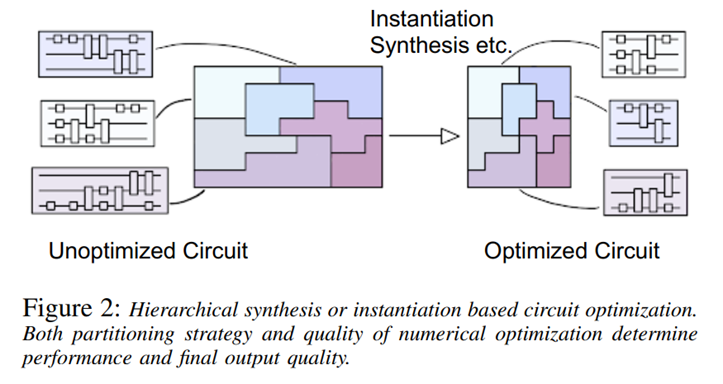

[1] QFactor: A Domain-Specific Optimizer for Quantum Circuit Instantiation – https://arxiv.org/pdf/2306.08152.pdf

### QSearch

**QSearch** is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters.

1) The algorithm starts by placing single-qubit rotations on all qubits. 

2) The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary. 

3) After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits. 

This branching pattern forms the circuit tree, where at depth n in the tree, all possible circuit structures with n two-qudit gates exist. 

Each structure is a candidate solution is evaluated using the same numerical optimization process, and the order of evaluations is determined by A* search.